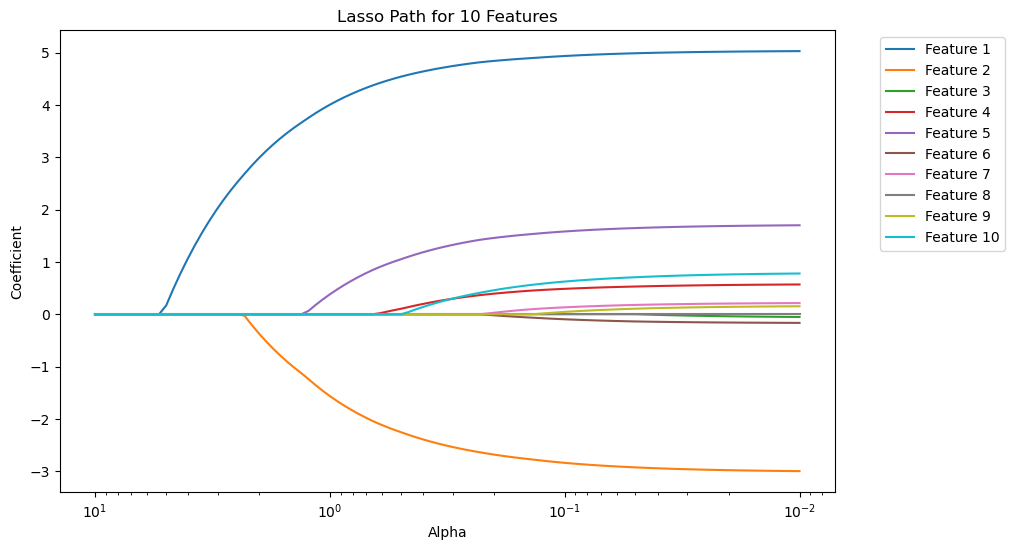

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import lasso_path
import pandas as pd 

# define X and y
df = pd.read_csv('data.csv')  # replace 'data.csv' with your actual data file
y = 
X = 

# generate synthetic data
# np.random.seed(0)
# n_samples, n_features = 100, 10
# X = np.random.randn(n_samples, n_features)  # 10 features
# true_coefs = np.array([5, -3, 0, 0, 2, 0, 0, 0, 0, 1])  # some true coefficients
# y = X @ true_coefs + np.random.randn(n_samples) * 2     # target with noise

# Compute Lasso path
alphas, coefs, _ = lasso_path(X, y, alphas=np.logspace(-2, 1, 100))

# Plot the Lasso path
plt.figure(figsize=(10,6))
for i in range(X.shape[1]):
    plt.plot(alphas, coefs[i], label=f'Feature {i+1}')
plt.xlabel('Alpha')
plt.ylabel('Coefficient')
plt.title('Lasso Path')
plt.xscale('log')
plt.gca().invert_xaxis()  # High alphas on the left
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

